In [1]:
import sys
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

sys.path.append('../..')
from epipy.sparse import rigid_csr_matrix

In [2]:
def sc_csr_base(data, row, col, n):
    mat = csr_matrix((data,(row, col)), shape=(n,n))
    
def sc_coo_base(data, row, col, n):
    mat = coo_matrix((data,(row, col)), shape=(n,n)).tocsr()
    
def sc_rigix_csr(data, row, col, n):
    mat = rigid_csr_matrix((data, (row, col)), shape=(n,n))
    
def sc_cp(data, row, col, n):
    cmat = cp_coo_matrix((data, (row, col)), shape=(n,n)).tocsr()
    
def npcopy_base(row, col, data):
    a=np.copy(row)
    b=np.copy(col)
    c=np.copy(data)
    
@jit(nopython=True)
def npcopy_nb(row, col, data):
    a=np.copy(row)
    b=np.copy(col)
    c=np.copy(data)
    
@jit(nopython=True, parallel=True)
def npcopy_nb_parallel(row, col, data):
    a = np.zeros(row.shape[0])
    for i in prange(row.shape[0]):
        a[i] = row[i]
    b = np.zeros(col.shape[0])
    for i in prange(col.shape[0]):
        b[i] = col[i]
    c = np.zeros(data.shape[0])
    for i in prange(data.shape[0]):
        c[i] = data[i]

In [3]:
# n = 2965820
# row, col = np.random.randint(0, n, (2, n))
# data = np.random.rand(n)
# npcopy_nb_parallel(row, col, data)
# npcopy_nb_parallel.parallel_diagnostics(level=4)

In [4]:
N = [int(8*(2**0.5)**i) for i in range(38)]
print(N)

[8, 11, 16, 22, 32, 45, 64, 90, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2896, 4096, 5792, 8192, 11585, 16384, 23170, 32768, 46340, 65536, 92681, 131072, 185363, 262144, 370727, 524288, 741455, 1048576, 1482910, 2097152, 2965820]


In [5]:
SIZE = 50000
methods = ["sc_csr_base", "sc_coo_base", "sc_rigix_csr", "sc_cp", "npcopy_base", "npcopy_nb", "npcopy_nb_parallel"]
K = len(methods)
funcs = [sc_csr_base, sc_coo_base, sc_rigix_csr, sc_cp, npcopy_base, npcopy_nb, npcopy_nb_parallel]
masks = [1, 1, 1, 1, 1, 1, 1]
groups = [0, 0, 0, 0, 1, 1, 1]
T = [[] for i in range(K)]
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n))
    data = np.random.rand(n)

    crow = cp.array(row)
    ccol = cp.array(col)
    cdata = cp.array(data)
    
    args = [(data, row, col, n), (data, row, col, n), (data, row, col, n), (cdata, crow, ccol, n), (row, col, data), (row, col, data), (row, col, data)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 3 -o funcs[i](*args[i])
        T[i].append(t.average*1000)

Start with size: 8


/home/alm818/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-2-04b065a5970c>", line 25:
@jit(nopython=True, parallel=True)
def npcopy_nb_parallel(row, col, data):
^

  state.func_ir.loc))


Start with size: 11
Start with size: 16
Start with size: 22
Start with size: 32
Start with size: 45
Start with size: 64
Start with size: 90
Start with size: 128
Start with size: 181
Start with size: 256
Start with size: 362
Start with size: 512
Start with size: 724
Start with size: 1024
Start with size: 1448
Start with size: 2048
Start with size: 2896
Start with size: 4096
Start with size: 5792
Start with size: 8192
Start with size: 11585
Start with size: 16384
Start with size: 23170
Start with size: 32768
Start with size: 46340
Start with size: 65536
Start with size: 92681
Start with size: 131072
Start with size: 185363
Start with size: 262144
Start with size: 370727
Start with size: 524288
Start with size: 741455
Start with size: 1048576
Start with size: 1482910
Start with size: 2097152
Start with size: 2965820


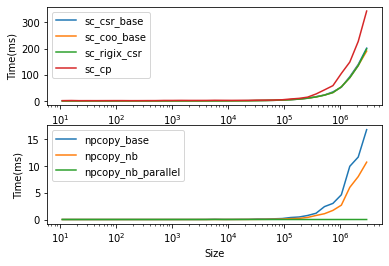

In [6]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [7]:
print(T)

[[0.21415966572628045, 0.18926533327127495, 0.2201336671229607, 0.21675099803057188, 0.18802333336983187, 0.22011866652367948, 0.1792063339962624, 0.21150999964447692, 0.18001066685731834, 0.24181566671662344, 0.19876866645063274, 0.25924399839520146, 0.24889699974058505, 0.20261533306135485, 0.21580533333083926, 0.22566766832217885, 0.2511923327498759, 0.2704350008571055, 0.3117823325737845, 0.365717665166206, 0.6287113343811749, 0.5386523334891535, 0.7263843338781347, 0.9640743337513413, 1.3691020006566152, 1.7446046658733394, 2.370020333425297, 3.4154250000331863, 4.821319665400854, 7.1291803336256026, 10.211002999615934, 16.357382666077076, 22.60310066655317, 34.52327366661242, 52.5059126666747, 92.48955500030813, 139.29422433284344, 201.74433933304195], [0.11820233460942593, 0.11866533410890649, 0.1202669979344743, 0.11580866824563903, 0.12147233186018032, 0.11662233373499475, 0.17863566608866677, 0.1185649998660665, 0.12537200018414296, 0.12207699910504743, 0.12615966746428361, 0